# Compute autocorrelation

Autocorrelation
$$ \sigma_{\overline{y}} = \dfrac{1}{\sqrt{N}} \sigma_{y} \times \sqrt{2\tau_{int}}$$ 

where $$ \tau_{int} = \dfrac{1}{2} + \sum_{t=1}^{N-1} \dfrac{C_y(t)}{C_y(0)}.$$

$$C_y(t)  =(1-\dfrac{t}{N})\bigl( \langle y_i y_{i+t} \rangle - \langle y_i \rangle  \langle y_{i+t}\rangle\bigr) \approx (1-\dfrac{t}{N})\langle (y_i - \overline{y})( y_{i+t} - \overline{y}) \rangle $$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [2]:
#read the Markov chain file
ls = []
with open('codec/out','r') as file:
    for line in file:
        ls.append(int(line.strip()))
mkchain = np.array(ls)
obs_err_naive = 0
obs_err = 0
size = len(mkchain)
for num in mkchain:
    obs_err += num*num
obs_err_naive = np.sqrt(obs_err*size - sum(mkchain)**2)/size/np.sqrt(size)

In [3]:
def calc_autocorr_chunk(args):
    """Calculate autocorrelation for a specific tau over a chunk of data"""
    tau, chunk, mkchain, mean = args
    partial_sum = 0
    start_idx = chunk[0]
    end_idx = chunk[1]
    
    for i in range(start_idx, end_idx - tau):
        partial_sum += (mkchain[i] - mean) * (mkchain[i + tau] - mean)
    
    return partial_sum

In [ ]:
def parallel_autocorr(mkchain, N_tau=200, num_cores=12):
    size = len(mkchain)
    obs_mean = np.mean(mkchain)
    autocorr = np.zeros(N_tau)
    flag = 0
    integrate = 0
    
    # Create chunk boundaries
    chunk_size = size // num_cores
    chunks = [(i, min(i + chunk_size, size)) for i in range(0, size, chunk_size)]
    
    # Adjust chunks if we have more than num_cores due to integer division
    if len(chunks) > num_cores:
        chunks[-2] = (chunks[-2][0], chunks[-1][1])
        chunks.pop()
    
    with Pool(processes=num_cores) as pool:
        for tau in range(N_tau):
            # Prepare arguments for each chunk
            chunk_args = [(tau, chunk, mkchain, obs_mean) for chunk in chunks]
            
            # Calculate partial sums in parallel
            partial_sums = pool.map(calc_autocorr_chunk, chunk_args)
            
            # Combine results
            autocorr[tau] = sum(partial_sums) / (size - tau)
            
            print(f"Autocorrelation at tau={tau}: {autocorr[tau]}")
            
            # Check for negative autocorrelation
            if (autocorr[tau] < 0) & (flag ==0):
                print(f"The stop point of integrand is t = {tau}")
                integrate = tau
                flag = 1
    
    return autocorr, integrate

autocorr, integrate = parallel_autocorr(mkchain, N_tau=200, num_cores=12)

Autocorrelation at tau=0: 2.489202519122632
Autocorrelation at tau=1: 1.207806064127275
Autocorrelation at tau=2: 0.6433272977502763
Autocorrelation at tau=3: 0.36118492632356086
Autocorrelation at tau=4: 0.20945970187470694
Autocorrelation at tau=5: 0.12424640595587753
Autocorrelation at tau=6: 0.07319723861495848
Autocorrelation at tau=7: 0.043742525437922744
Autocorrelation at tau=8: 0.02586956538828941
Autocorrelation at tau=9: 0.016166983993709888
Autocorrelation at tau=10: 0.00962117819656082
Autocorrelation at tau=11: 0.006475799954534286
Autocorrelation at tau=12: 0.004067148576036873
Autocorrelation at tau=13: 0.003854400065362415
Autocorrelation at tau=14: 0.0024260478306351928
Autocorrelation at tau=15: 0.0019618213852355907
Autocorrelation at tau=16: 0.0008758445945647081
Autocorrelation at tau=17: 0.0016542200137105566
Autocorrelation at tau=18: 0.001705593784978137
Autocorrelation at tau=19: 0.0012156177752952761
Autocorrelation at tau=20: 0.0017243929227254893
Autocorrel

In [5]:
result = 0
for tau in range(integrate):
    result += autocorr[tau]/autocorr[0]*(1-tau/integrate)
result = (1/2+result)
print("Our observable expect:", 1.25)
print('-'*30)
print("The observale mean:", np.mean(mkchain))
print('-'*30)
print("The naive observale error:", obs_err_naive)
print("The range of results [",np.mean(mkchain) - obs_err_naive, ",",np.mean(mkchain) + obs_err_naive, "]")
print('-'*30)
print("The correct observale error:", np.sqrt(2*result)*obs_err_naive)
print("The range of results [",np.mean(mkchain) - np.sqrt(2*result)*obs_err_naive, ",",np.mean(mkchain) + np.sqrt(2*result)*obs_err_naive, "]")


Our observable expect: 1.25
------------------------------
The observale mean: 1.2512373
------------------------------
The naive observale error: 0.0004989190835284525
The range of results [ 1.2507383809164716 , 1.2517362190835286 ]
------------------------------
The correct observale error: 0.0011179536714515
The range of results [ 1.2501193463285487 , 1.2523552536714515 ]


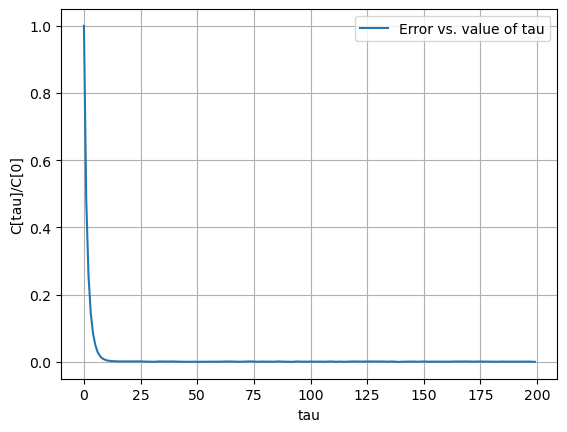

In [16]:
tau = np.arange(0,200)
au = np.array([autocorr[tau]/autocorr[0] for tau in range(0,200)])
plt.plot(tau, au, label='Error vs. value of tau')  # Added a label for the legend
plt.xlabel('tau')  # X-axis label
plt.ylabel('C[tau]/C[0]')  # Y-axis label
# plt.loglog()
plt.grid()
plt.legend()
plt.show()  # Show the plot

# Using Blocking method

1. Divide N mesurements into $n_b$ blocks with $N_b$ elements
$$ N  = n_b* N_b $$
2. Compute observable on each block
$$ O_{(i) \in (1,n_b)} = \dfrac{1}{N_b} \sum_{j = 1}^{N_b} O_{j}$$
3. Compute the block-average
$$\overline{O} = \dfrac{1}{n_b} \sum_{i = 1}^{n_b} O_{(i)}$$
4. Compute block-variance
$$ \sigma_{\overline{O}} = \dfrac{1}{\sqrt{n_b}} \sqrt{\dfrac{1}{n_b} \sum_{i = 1}^{n_b}O_{(i)}^2 - \overline{O}^2}$$